# Colab Configs

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [ ]:
%cd /content/drive/My Drive/Side Projects/Upwork/Equeum

/content/drive/My Drive/Side Projects/Upwork/Equeum


# Imports

In [ ]:
!pip install -q webhoseio jsonlines rake-nltk

In [ ]:
import webhoseio
import json
import pandas as pd
import numpy as np
import plotly
from tqdm.notebook import tqdm
import jsonlines
import os
import sys
import plotly.graph_objects as go
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from wordcloud import WordCloud, STOPWORDS
from collections import Counter
from rake_nltk import Rake
import nltk
from nltk.corpus import stopwords
import string  
from itertools import chain



!python -c "import nltk; nltk.download('stopwords')"

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


# Utils

In [ ]:
class WebhoseDataCollector:
    def __init__(self, webhose_token):
        webhoseio.config(token=webhose_token)

    def get_webhose_data(self, query_params):
        output = webhoseio.query("filterWebContent", query_params)
        while True:
            if len(output['posts']) < 1 or output['requestsLeft'] == 0:
                break
            for article in output['posts']:
                yield article
            output = webhoseio.get_next()

In [ ]:
def save_json(file_path, data):
    with open(file_path, 'w') as f:
        json.dump({"all_data": data}, f)
    print("Done!")

In [ ]:
def read_json(file_path):
    with open(file_path) as f:
        return json.load(f)

In [ ]:
def construct_data_frame(list_articles):
    data = {'uuid': [], 'crawled_date': [], 'crawled_time': [], 'published_date': [], 'published_time': [], 
            'author': [], 'article_title': [], 'article_body': [], 'language': [], 'country': [], 'entities': [], 
            'article_url': [], 'section_title': [], 'site': [], 'site_categories': [], 'site_type': [], 
            'domain_rank': [], 'spam_score': [], 'query_filter': [], 'time_stamp': []
            }
    for i in tqdm(list_articles):
        query_filter = i['query_filter']
        for a in i['data']:
            a = json.loads(a)
            data['uuid'].append(a['uuid'])
            data['crawled_date'].append(a['crawled'].split('T')[0])
            data['crawled_time'].append(a['crawled'].split('T')[1].split('.')[0])
            data['published_date'].append(a['published'].split('T')[0])
            data['published_time'].append(a['published'].split('T')[1].split('.')[0])
            data['author'].append(a['author'])
            data['article_title'].append(a['title'])
            data['article_body'].append(a['text'])
            data['language'].append(a['language'])
            data['country'].append(a['thread']['country'])
            data['entities'].append(a['entities'])
            data['article_url'].append(a['url'])
            data['section_title'].append(a['thread']['section_title'])
            data['site'].append(a['thread']['site'])
            data['site_categories'].append(' '.join(a['thread']['site_categories']))
            data['site_type'].append(a['thread']['site_type'])
            data['domain_rank'].append(a['thread']['domain_rank'])
            data['spam_score'].append(a['thread']['spam_score'])
            data['query_filter'].append(query_filter)
            data['time_stamp'].append(pd.to_datetime(a['published']))

    return pd.DataFrame(data)


In [ ]:
def plot(x, y, xaxis_title, yaxis_title, figure_title,show_legend=True):
    fig = go.Figure(data=[go.Bar(
                x=x, y=y,
                text=y,
                textposition='auto',
            )])
    fig.update_layout(
        showlegend=show_legend,
        title=figure_title,
        xaxis_title=xaxis_title,
        yaxis_title=yaxis_title
        )
    fig.show()

# Get the Data from webhose.io API & Save it

## Initializing

In [ ]:
webhose_token="3351ead4-3a41-4445-adf0-9acdd6528712"

In [ ]:
webhose_data_collector = WebhoseDataCollector(webhose_token=webhose_token)

## Any Mention of Microsoft in any news website

* Any mention (in article tiltle or body) of these keywords that refers to Microsoft:
> `Microsoft` `microsoft` `MICROSOFT` `MSFT` `msft`
* Search in news websites only.

In [ ]:
query_params = {

"q": "(MSFT OR Microsoft OR msft OR microsoft OR MICROSOFT) language:english site_type:news",

"ts": "1589700546682",

"sort": "crawled"

}

In [ ]:
with jsonlines.open('data/microsoft_news.jsonl', mode='w') as w:
    w.write({'query_params': query_params})
    for i in webhose_data_collector.get_webhose_data(query_params=query_params):
        w.write(i)

## Any Mention of Microsoft in any Financial news website

* Any mention (in article tiltle or body) of these keywords that refers to Microsoft:
> `Microsoft` `microsoft` `MICROSOFT` `MSFT` `msft`
* Search in news websites only, and that website must be classified as `financial news wesite`.

In [ ]:
query_params = {

"q": "(MSFT OR Microsoft OR msft OR microsoft OR MICROSOFT) language:english site_type:news site_category:financial_news",

"ts": "1589700625790",

"sort": "crawled"

}

In [ ]:
with jsonlines.open('data/microsoft_financial_news.jsonl', mode='w') as w:
    w.write({'query_params': query_params})
    for i in webhose_data_collector.get_webhose_data(query_params=query_params):
        w.write(i)

## Any Mention of Microsoft Ticker in news websites



* Any mention (in article tiltle or body) of these keywords that refers to Microsoft's ticker:
> `MSFT` `msft`
* Search in news websites only.

In [ ]:
query_params = {

"q": "(MSFT OR msft) language:english site_type:news",

"ts": "1589700694203",

"sort": "crawled"

}

In [ ]:
with jsonlines.open('data/microsoft_ticker_news.jsonl', mode='w') as w:
    w.write({'query_params': query_params})
    for i in webhose_data_collector.get_webhose_data(query_params=query_params):
        w.write(i)

## Any Mention of Microsoft Ticker in any Financial news website

* Any mention (in article tiltle or body) of these keywords that refers to Microsoft's ticker:
> `MSFT` `msft`
* Search in news websites only, and that website must be classified as `financial news wesite`.

In [ ]:
query_params = {

"q": "(MSFT OR msft) language:english site_type:news site_category:financial_news",

"ts": "1589700657462",

"sort": "crawled"

}

In [ ]:
with jsonlines.open('data/microsoft_ticker_financial_news.jsonl', mode='w') as w:
    w.write({'query_params': query_params})
    for i in webhose_data_collector.get_webhose_data(query_params=query_params):
        w.write(i)

# Extract Relevent Data & Save it

In [ ]:
c = 0
j = None
with jsonlines.open('data/microsoft_news.jsonl') as f:
    for i in f:
        if c == 1:
            j = i
            break
        c += 1

In [ ]:
_temp_df = pd.DataFrame({"Fields": list(chain.from_iterable([v.keys() for k,v in j.items() if isinstance(v, dict)]))})

In [ ]:
_temp_df

,Fields
0,uuid
1,url
2,site_full
3,site
4,site_section
5,site_categories
6,section_title
7,title
8,title_full
9,published


In [ ]:
list_articles = []
for file in os.listdir('data'):
    if not file.startswith('microsoft_'):
        continue
    with open(f'data/{file}') as f:
        list_articles.append({'query_filter': file.split('.')[0], 'data':f.readlines()[1:]})

In [ ]:
df = construct_data_frame(list_articles)

In [ ]:
set(_temp_df['Fields']) - set((list(df.columns)) + ['locations', 'organizations', 'persons', 'published', 'site_section', 'title', 'url'])

{'main_image',
 'participants_count',
 'performance_score',
 'replies_count',
 'site_full',
 'social',
 'title_full'}

In [ ]:
df = df.loc[df.astype(str).drop_duplicates().index].reset_index(drop=True)

In [ ]:
df

,uuid,crawled_date,crawled_time,published_date,published_time,author,article_title,article_body,language,country,entities,article_url,section_title,site,site_categories,site_type,domain_rank,spam_score,query_filter,time_stamp
0,77af1358dd98f9e758bedc920e34ba377a9c7048,2020-05-17,10:32:12,2020-05-17,10:00:00,Roger Anghis,"Bill Gates’ Hand In COVID-19, Part 2","Bill Gates’ Hand In COVID-19, Part 2 Bill Gat...",english,US,"{'persons': [{'name': 'bill gates', 'sentiment...",https://newswithviews.com/bill-gates-hand-in-c...,News With Views,newswithviews.com,media financial_news finance,news,NaN,0.0,microsoft_financial_news,2020-05-17 10:00:00+03:00
1,191f7395e1583f4d96a0ecf8e885feec914ef814,2020-05-17,12:10:11,2020-05-17,11:32:00,ABMN Staff,Microsoft Co. (NASDAQ:MSFT) Holdings Lifted by...,Transform Wealth LLC grew its holdings in shar...,english,US,"{'persons': [{'name': 'charles', 'sentiment': ...",https://www.americanbankingnews.com/2020/05/17...,American Banking News,americanbankingnews.com,financial_news finance,news,NaN,0.0,microsoft_financial_news,2020-05-17 11:32:00+03:00
2,e87f6a68448aa137d92af501fcd1d5fddbc710e3,2020-05-17,12:11:31,2020-05-17,11:32:00,ABMN Staff,Microsoft Co. (NASDAQ:MSFT) Shares Bought by C...,Capital Wealth Planning LLC boosted its stake ...,english,US,"{'persons': [], 'organizations': [{'name': 'mi...",https://www.americanbankingnews.com/2020/05/17...,American Banking News,americanbankingnews.com,financial_news finance,news,NaN,0.0,microsoft_financial_news,2020-05-17 11:32:00+03:00
3,d072f3d22be331b054e3d415a74acd832135da02,2020-05-17,12:11:34,2020-05-17,11:32:00,ABMN Staff,Microsoft Co. (NASDAQ:MSFT) Stake Reduced by H...,Harbor Island Capital LLC cut its stake in Mic...,english,US,"{'persons': [], 'organizations': [{'name': 'mi...",https://www.americanbankingnews.com/2020/05/17...,American Banking News,americanbankingnews.com,financial_news finance,news,NaN,0.0,microsoft_financial_news,2020-05-17 11:32:00+03:00
4,c5c3839454b16a699a886aab4a6a9fd8ae626380,2020-05-17,12:11:36,2020-05-17,11:32:00,ABMN Staff,Microsoft Co. (NASDAQ:MSFT) Holdings Boosted b...,Robeco Institutional Asset Management B.V. gre...,english,US,"{'persons': [], 'organizations': [{'name': 'mi...",https://www.americanbankingnews.com/2020/05/17...,American Banking News,americanbankingnews.com,financial_news finance,news,NaN,0.0,microsoft_financial_news,2020-05-17 11:32:00+03:00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
59006,3bea1bfc3649dad9899b7b5ed333bc0c53b6411a,2020-06-16,10:41:15,2020-06-15,19:11:00,mpolino,Blog Post: Bad Parameter in refreshable Excel ...,SBX - Syndicated Blog Identification Banner PL...,english,US,"{'persons': [], 'organizations': [{'name': 'mi...",http://feedproxy.google.com/~r/DynamicAccounti...,Microsoft Dynamics GP,google.com,advertising business,news,1.0,0.0,microsoft_news,2020-06-15 19:11:00+03:00
59007,8ddab67a9b3ea67262d7f6812172652d2e6ed21d,2020-06-16,10:41:36,2020-06-16,04:25:00,,Stephen Moore: Don't break up Big Tech,It's the oddest thing. The more America's Big ...,english,US,"{'persons': [{'name': 'stephen moore', 'sentim...",https://oklahoman.com/article/5664658/stephen-...,NewsOK.com RSS - home >> !The Oklahoman,oklahoman.com,media,news,NaN,0.0,microsoft_news,2020-06-16 04:25:00+03:00
59008,7f2bf789c462871d599902bc5b43cc145a9dd565,2020-06-16,10:41:49,2020-06-16,08:31:00,,Conformance Inspector,Hours - Full time - 37.5 hours per week Indust...,english,GB,"{'persons': [], 'organizations': [{'name': 'in...",https://www.technojobs.co.uk/job/2832548/confo...,Latest Jobs : Technojobs.co.uk,technojobs.co.uk,job_search jobs,news,NaN,0.0,microsoft_news,2020-06-16 08:31:00+03:00
59009,e0616db58122644494f038fb2bf43f560770637b,2020-06-16,10:42:56,2020-06-16,08:00:00,,".NET Developer, .NET Core, C# -Investment Bank...",".NET Developer, .NET Core, C#, SQL Server - In...",english,GB,"{'persons': [], 'organizations': [{'name': 'c#...",https://www.technojobs.co.uk/job/28325

In [ ]:
df.to_csv('data/Microsoft_Data.csv', index=False)

# Data Analysis

In [ ]:
df = pd.read_csv('data/Microsoft_Data.csv')

In [ ]:
plot(x=list(df['query_filter'].value_counts().keys()), y=list(df['query_filter'].value_counts().values), xaxis_title='Query', yaxis_title='Number of matched results (Articles)', figure_title='Queries distribution',show_legend=True)

In [ ]:
n_pub_over_time_df = df.groupby(['query_filter', 'published_date', 'country']).size().reset_index()
n_pub_over_time_df['published_date'] = pd.to_datetime(n_pub_over_time_df['published_date'])
n_pub_over_time_df.columns = ['query_filter', 'published_date', 'country', 'count']

Number of publication over time for each query type

---


In [ ]:
px.line(n_pub_over_time_df, x='published_date', y='count', color='query_filter', line_dash='country').show()

In [ ]:
px.scatter_3d(n_pub_over_time_df, x='published_date', y='count', z='country', color='query_filter').show()

In [ ]:
def s(text):
    try:
        return text.split()[-1]
    except:
        return text

In [ ]:
_df = df.groupby(['site_categories', 'published_date']).size().reset_index()
_df['published_date'] = pd.to_datetime(_df['published_date'])
_df['site_categories'] = _df['site_categories'].apply(s)
_df.columns = ['site_category', 'published_date', 'count']

In [ ]:
px.scatter_3d(_df, x='published_date', y='count', z='site_category', color='site_category').show()

In [ ]:
df 

,uuid,crawled_date,crawled_time,published_date,published_time,author,article_title,article_body,language,country,entities,article_url,section_title,site,site_categories,site_type,domain_rank,spam_score,query_filter
0,77af1358dd98f9e758bedc920e34ba377a9c7048,2020-05-17,10:32:12,2020-05-17,10:00:00,Roger Anghis,"Bill Gates’ Hand In COVID-19, Part 2","Bill Gates’ Hand In COVID-19, Part 2 Bill Gat...",english,US,"{'persons': [{'name': 'bill gates', 'sentiment...",https://newswithviews.com/bill-gates-hand-in-c...,News With Views,newswithviews.com,media financial_news finance,news,NaN,0.000,microsoft_news
1,d5f4faba3e6817b2724af8c6320140587e055189,2020-05-17,10:33:24,2020-05-17,09:13:00,Finance News,Why is Wall Street smiling when the economy co...,New York (hooly News) – The pandemic has knock...,english,US,"{'persons': [{'name': 'sam stovall', 'sentimen...",https://r.search.yahoo.com/_ylt=AwrXgyLM0MBevn...,Good Stock Invest,yahoo.com,search_engine tech,news,5.0,0.000,microsoft_news
2,a64e1044c3e4b8399d1e79645b3eca435ea6097a,2020-05-17,10:44:26,2020-05-17,03:00:00,NaN,Stock Market Today: Trade Tensions Flare; Face...,Share on Pinterest\nThe S&P 500 gapped down on...,english,DE,"{'persons': [{'name': 'donald trump', 'sentime...",https://stocksdiscovery.com/2020/05/17/stock-m...,NaN,stocksdiscovery.com,NaN,news,NaN,0.003,microsoft_news
3,004f9f6f74a51b98009d81ce70771e580234fcb6,2020-05-17,10:48:26,2020-05-17,08:00:00,Delle Chan,"Smart, low-carbon mini grids are putting power...",The entrepreneur is rethinking grids to provid...,english,GB,"{'persons': [{'name': 'elizabeth nyeko', 'sent...",https://www.wired.co.uk/article/mini-power-grids,WIRED UK,wired.co.uk,non_standard_content,news,11983.0,0.000,microsoft_news
4,3dfcec9b341f60ade2dc270150955faad8e91190,2020-05-17,10:48:53,2020-05-17,09:32:00,NewsBytes,"Windows 10 update causes data loss, broken aud...","A few days back, Microsoft released an update ...",english,IN,"{'persons': [], 'organizations': [{'name': 'mi...",https://m.dailyhunt.in/news/india/english/news...,NaN,dailyhunt.in,media,news,14412.0,0.141,microsoft_news
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
59006,a565f88c7b178b7ebec00b7c70056eb2861c9866,2020-06-16,06:56:21,2020-06-15,03:00:00,PRNewswire,Bango Launches SoftBank Payment Option for Ama...,- SoftBank customers can use carrier billing t...,english,US,"{'persons': [{'name': 'bango', 'sentiment': 'n...",https://www.gurufocus.com/news/1163144/bango-l...,Dividend Stocks - GuruFocus.com,gurufocus.com,investing financial_news finance,news,9311.0,0.645,microsoft_ticker_financial_news
59007,b7831e21f63d60c646cbe13ef3f8679c227cef3a,2020-06-16,07:05:18,2020-06-15,23:52:00,Tradechat,"3 Large-Cap, Dividend-Paying Tech Stocks to Bu...",On today’s episode of Full Court Finance here ...,english,NaN,"{'persons': [{'name': 'ben rains', 'sentiment'...",https://mrtopstep.com/3-large-cap-dividend-pay...,MrTopStep.com,mrtopstep.com,stocks finance financial_news,news,NaN,0.000,microsoft_ticker_financial_news
59008,055cffcf6d487040cbaa1f01207c5d72288bafa6,2020-06-16,07:53:59,2020-06-15,03:00:00,Zacks Equity Research,Microsoft (MSFT) Gains But Lags Market: What Y...,Microsoft ( MSFT - Free Report ) closed the mo...,english,US,"{'persons': [], 'organizations': [{'name': 'za...",https://www.zacks.com/stock/news/985015/micros...,Zacks Investment Research - All Commentary Art...,zacks.com,financial_news finance mutual_funds,news,4749.0,0.000,microsoft_ticker_financial_news
59009,d62342d9c3630726edeb969f3eb36e116780138a,2020-06-16,09:04:47,2020-06-16,08:28:00,ABMN Staff,Microsoft (NASDAQ:MSFT) Receiving Somewhat Cri...,Headlines about Microsoft (NASDAQ:MSFT) have b...,english,US,"{'persons': [{'name': 'piper sandler', 'sentim...",https://www.americanbankingnews.com/2020/06/16...,American Banking News,americanbankingnews.com,financial_news finance,news,NaN,0.000,microsoft_ticker_financial_news


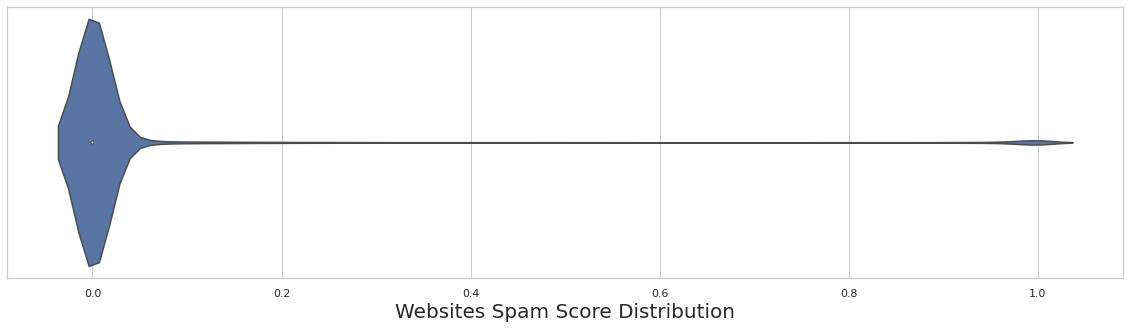

In [ ]:
plt.figure(figsize=(20, 5))
sns.violinplot(df['spam_score'])
plt.xlabel('Websites Spam Score Distribution', fontdict={'size': 20})
plt.show()

**The above Violin Plot tells us:**

Most of the *websites*, we got results from, has a very low spam score < 0.2

In [ ]:
round(np.median(df[(df['spam_score'] < 0.2) & (df['query_filter'] == 'microsoft_news')]['spam_score']), 5)

0.0

In [ ]:
ssp = [len(df[(df['spam_score'] < 0.2) & (df['query_filter'] == 'microsoft_news')]['spam_score'])*100/len(df[df['query_filter'] == 'microsoft_news']),
 len(df[(df['spam_score'] < 0.2) & (df['query_filter'] == 'microsoft_financial_news')]['spam_score'])*100/len(df[df['query_filter'] == 'microsoft_financial_news']),
 len(df[(df['spam_score'] < 0.2) & (df['query_filter'] == 'microsoft_ticker_news')]['spam_score'])*100/len(df[df['query_filter'] == 'microsoft_ticker_news']),
 len(df[(df['spam_score'] < 0.2) & (df['query_filter'] == 'microsoft_ticker_financial_news')]['spam_score'])*100/len(df[df['query_filter'] == 'microsoft_ticker_financial_news']),
]

In [ ]:
plot(x=list(df['query_filter'].value_counts().keys()), y=ssp, xaxis_title='Query', yaxis_title='Percentage of website with spam scores less than 0.2', figure_title='Spam Score distribution',show_legend=True)

This mean than the skewness to wright in the previous Violin Plot is not for single search query, the websites with spam score higher than 0.2 is almost evenly distrubuted among the 4 queries.

In [ ]:
df['site_categories'].value_counts()

816

In [ ]:
_df_ = pd.DataFrame({'site_category': list(df['site_categories'].value_counts().keys()), 'counts': list(df['site_categories'].value_counts().values)})
_df_2 = _df_[_df_['counts']>100]

In [ ]:
plot(x=_df_2['site_category'].to_list(), y=_df_2['counts'].to_list(), xaxis_title='', yaxis_title='', figure_title='')

In [ ]:
fig = px.pie(_df_2, values='counts', names='site_category')
fig.show()

**The above graphs shows:**

The contripution (Number of articles) of the websites accross different categories.
I selected only the websites that published at least 100 articles about Microsoft.



Articles' Titles Most Frequent Words

---


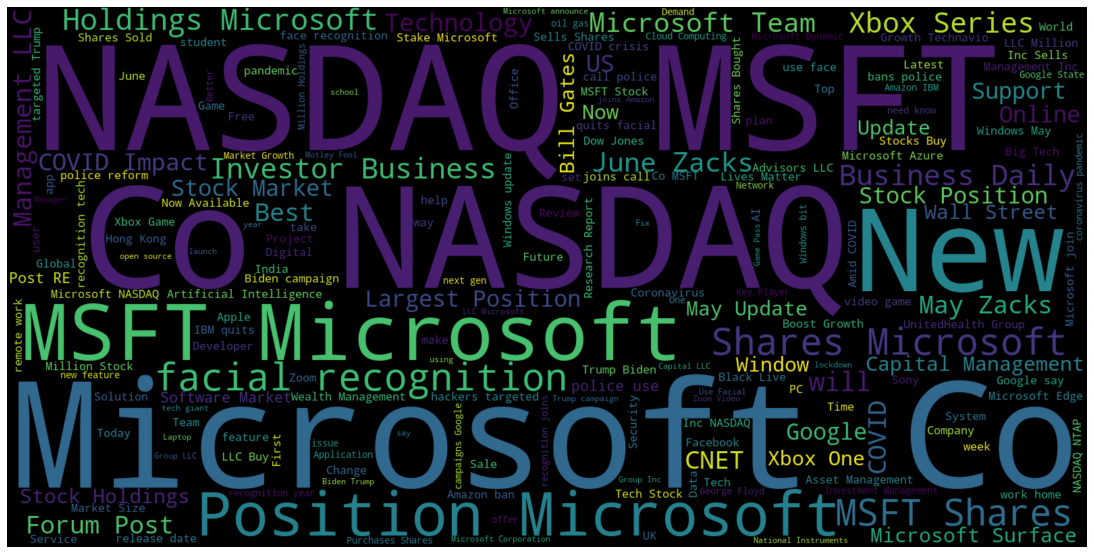

In [ ]:
cloud = WordCloud(stopwords=STOPWORDS, background_color='black', width=1600, height=800).generate(' '.join([i for i in df['article_title'].to_list() if isinstance(i, str)]))
plt.figure(figsize=(15, 15), facecolor=None)
plt.imshow(cloud, interpolation="bilinear")
plt.axis("off")
plt.tight_layout(pad=0)
plt.show()

In [ ]:
frequency_counter = Counter()
for i in df['article_body']:
    if not isinstance(i, str):
        continue
    frequency_counter.update(i.split())
c_ = frequency_counter.copy()
for word in list(frequency_counter):
    if word in STOPWORDS or len(word) < 4:
        del c_[word]

Articles' Body Most Frequent Words

---


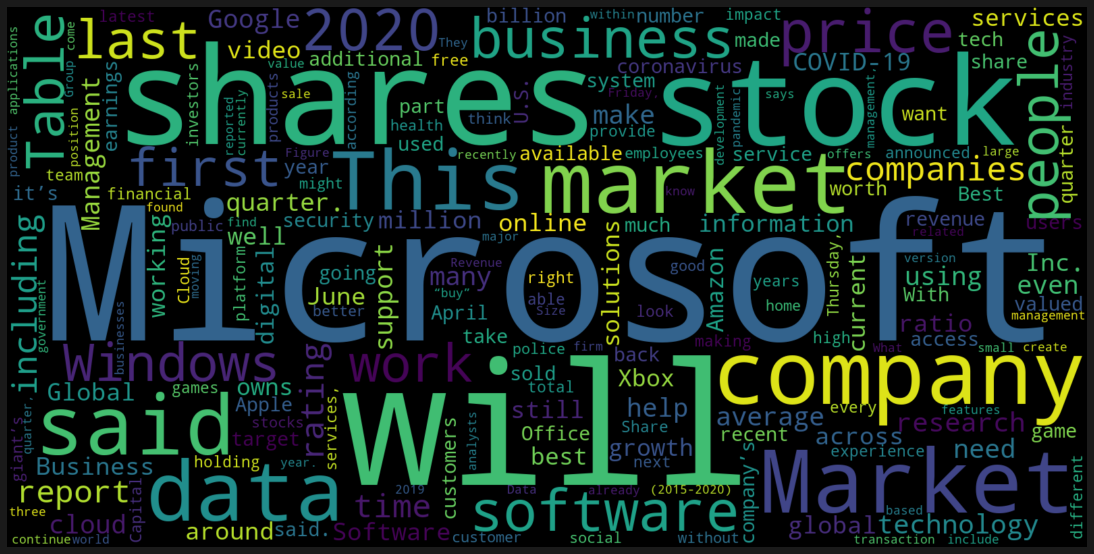

In [ ]:
cloud = WordCloud(stopwords=STOPWORDS, background_color='black', width=1600, height=800).generate_from_frequencies(c_)
plt.figure(figsize=(15, 15), facecolor='k')
plt.imshow(cloud, interpolation="bilinear")
plt.axis("off")
plt.tight_layout(pad=0)
plt.show()

In [ ]:
entities_ = {'persons': [], 'persons_sentiment': [], 'organizations': [], 'organizations_sentiment': [], 'locations':[], 'locations_sentiment': []}
for i in tqdm(df['entities']):
    i = eval(i)
    for j, k, l in zip(i['persons'], i['organizations'], i['locations']):
        if len(j) > 0:
            entities_['persons'].append(j['name'])
            entities_['persons_sentiment'].append(j['sentiment'])
        else:
            entities_['persons'].append('')
            entities_['persons_sentiment'].append('')
        
        if len(k) > 0:
            entities_['organizations'].append(k['name'])
            entities_['organizations_sentiment'].append(k['sentiment'])
        else:
            entities_['organizations'].append('')
            entities_['organizations_sentiment'].append('')
        
        if len(l) > 0:
            entities_['locations'].append(l['name'])
            entities_['locations_sentiment'].append(l['sentiment'])
        else:
            entities_['locations'].append('')
            entities_['locations_sentiment'].append('')

entities_df = pd.DataFrame(entities_)

In [ ]:
entities_df

,persons,persons_sentiment,organizations,organizations_sentiment,locations,locations_sentiment
0,bill gates,none,microsoft,none,gavi,none
1,sam stovall,none,new york stock exchange,none,new york,none
2,donald trump,none,facebook,none,u.s.,none
3,elizabeth nyeko,none,world bank,none,sudan,none
4,matei zaharia,none,stanford university,none,delta lake,none
...,...,...,...,...,...,...
22247,ben rains,none,s&p,none,beijing,none
22248,len,none,cheniere energy inc,neutral,ny,none
22249,alp,negative,axa buys edwards lifesciences corp,negative,new york,none
22250,bango,negative,softbank,negative,cambridge,none


Key_words and Key_phrases extraction

---


> Try it on the first article

In [ ]:
r = Rake(language='en', stopwords=stopwords.words('english'), punctuations=string.punctuation + '''’‘““.©–,’.”''')

r.extract_keywords_from_text(df['article_body'][0])

print('Article Title: ', df['article_title'][0], '\n')

r.get_ranked_phrases_with_scores() # To get keyword phrases ranked highest to lowest.

Article Title:  Bill Gates’ Hand In COVID-19, Part 2 



[(30.25, 'top secret contingency plans already exist'),
 (28.25, '1 billion people living without identity'),
 (27.5, 'digital identity solutions ,’ kiva protocol'),
 (16.0, 'organizations whose primary functions'),
 (15.5, 'goals go beyond providing'),
 (15.0, 'massively scalable payment solution'),
 (14.5, '2030 sustainable development goals'),
 (14.333333333333334, 'basic human right .”'),
 (14.1, 'include rising global connectivity'),
 (14.0, 'native biometric identity system'),
 (14.0, '2019 world economic forum'),
 (13.666666666666668, 'identity .” everest defines'),
 (13.166666666666666, 'supreme court could also'),
 (10.5, 'providing legal identity'),
 (10.5, 'digital transaction protocol'),
 (10.5, 'combines biometric identity'),
 (10.016666666666667, 'part 2 bill gates'),
 (9.5, 'unique digital identity'),
 (9.333333333333334, 'provide legal identity'),
 (9.0, 'widespread domestic violence'),
 (9.0, 'united nations adopted'),
 (9.0, 'three weeks ago'),
 (9.0, 'rights reserved

In [ ]:
print(df['article_body'][0])

 Bill Gates’ Hand In COVID-19, Part 2 Bill Gates’ Hand In COVID-19, Part 2 By Roger Anghis | 2020-05-17T03:00:29-04:00 May 17th, 2020 |
Roger Anghis
We all know that vaccines are intended to protect people from disease saving lives in the process. Bill Gates intends to use vaccines for the opposite. He wants to use vaccines for human depopulation. He believes that we have to eliminate 350,000 people a day![1] I don’t know about you but if that’s his plan to depopulate, I don’t think I’ll participate in his ‘vaccine’ program.
There is another part of his evil plot and that’s a system to set up Global Digital Identification. Can you say Mark of the Beast? Call me a conspiracy theorist but it isn’t a conspiracy when they are doing it. Last September 2019, an annual summit was hosted by the ID2020 alliance, composed of significant partners from around the world. Microsoft, GAVI (Global Alliance of Vaccines and Immunizations), The Rockefeller Foundation, and a growing number of partners fro